In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c dogs-vs-cats

 93% 759M/812M [00:04<00:01, 44.4MB/s]
100% 812M/812M [00:04<00:00, 202MB/s] 


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
!unzip -q train.zip
!unzip -q test1.zip

In [5]:
import os, shutil, random


original_data_dir = '/content/train'

base_dir = '/content/data_split' # A new base directory for the split data
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

for split_path in [train_dir, val_dir]:
    for cat in ['cats', 'dogs']:
        os.makedirs(os.path.join(split_path, cat), exist_ok=True)

# List all files in the original_data_dir and categorize them
all_files = os.listdir(original_data_dir)
cat_files = [f for f in all_files if f.startswith('cat.') and f.endswith('.jpg')]
dog_files = [f for f in all_files if f.startswith('dog.') and f.endswith('.jpg')]

# Split and copy files for cats
random.shuffle(cat_files)
split_point_cat = int(0.8 * len(cat_files))

for f in cat_files[:split_point_cat]:
    shutil.copy(os.path.join(original_data_dir, f), os.path.join(train_dir, 'cats', f))
for f in cat_files[split_point_cat:]:
    shutil.copy(os.path.join(original_data_dir, f), os.path.join(val_dir, 'cats', f))

# Split and copy files for dogs
random.shuffle(dog_files)
split_point_dog = int(0.8 * len(dog_files))

for f in dog_files[:split_point_dog]:
    shutil.copy(os.path.join(original_data_dir, f), os.path.join(train_dir, 'dogs', f))
for f in dog_files[split_point_dog:]:
    shutil.copy(os.path.join(original_data_dir, f), os.path.join(val_dir, 'dogs', f))

print("✅ Train/Validation sets ready!")

✅ Train/Validation sets ready!


In [6]:
# transfer learning

from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [9]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
conv_base.trainable = False

In [12]:
# generators

train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/data_split/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/data_split/validation',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [13]:
# Normalize

def process(image, label):
  image = tf.cast(image/255., tf.float32)
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(train_ds, epochs=5, validation_data=validation_ds)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 89s 129ms/step - accuracy: 0.8603 - loss: 0.3244 - val_accuracy: 0.9118 - val_loss: 0.2125
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 124ms/step - accuracy: 0.9228 - loss: 0.1894 - val_accuracy: 0.8958 - val_loss: 0.2556
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 124ms/step - accuracy: 0.9335 - loss: 0.1591 - val_accuracy: 0.9178 - val_loss: 0.2103
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - accuracy: 0.9468 - loss: 0.1309 - val_accuracy: 0.9158 - val_loss: 0.2193
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - accuracy: 0.9602 - loss: 0.1024 - val_accuracy: 0.8970 - val_loss: 0.2878


<function matplotlib.pyplot.show(close=None, block=None)>

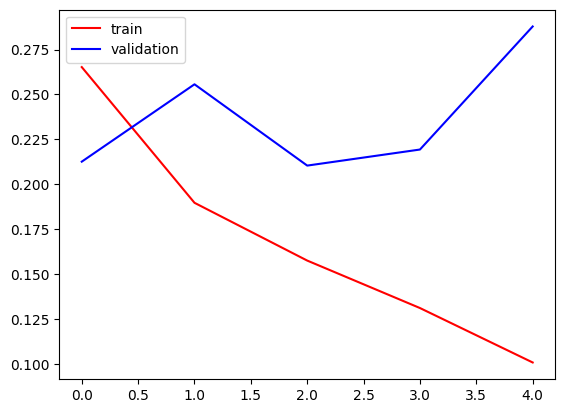

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

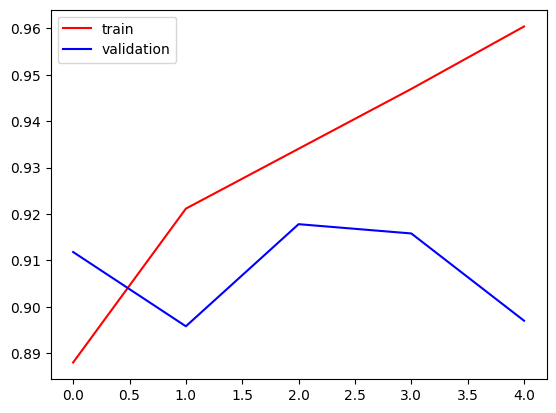

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show

In [31]:
import cv2
test_image1 = cv2.imread('/content/cat3.jpg')

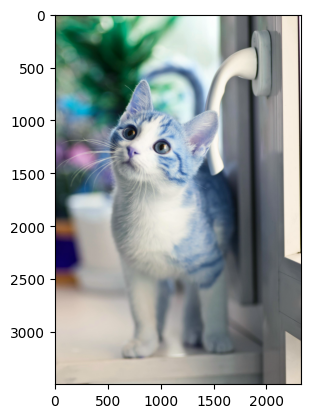

In [32]:
plt.imshow(test_image1)

In [33]:
test_image_resized = cv2.resize(test_image1, (150, 150))
test_input = test_image_resized.reshape((1, 150, 150, 3))

In [34]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


array([[1.]], dtype=float32)

157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step


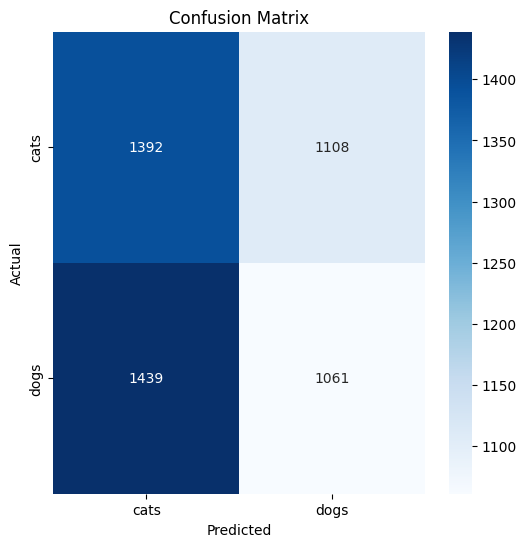

In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels from the validation_ds
y_true = []
for images, labels in validation_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Get predictions from the model
y_pred_prob = model.predict(validation_ds)
y_pred = (y_pred_prob > 0.5).astype(int)

# Ensure y_pred is a 1D array
y_pred = y_pred.flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names (assuming alphabetical order for 'cats' and 'dogs')
class_names = ['cats', 'dogs']

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# data augmentation
# improve epochs
# batch normalization and dropouts
# improve model structure